In [1]:
import numpy as np
import pandas as pd
import json
import ast
import pymongo
from matplotlib import pyplot as plt
path = '/media/flo/Stockage/Data/MesAides/tables/'

In [2]:
%qtconsole
%matplotlib inline

/usr/local/lib/python3.4/dist-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


# Individus

In [194]:
t_individus = pd.read_csv(path + "individus.csv", index_col=False)

/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (3,5,10,14,15,17,18,19,21,24,27,28,31,33,34,35,36,37,39,41,45,46,48,50,51,52,53,54) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [195]:
del t_individus['Unnamed: 0']

In [196]:
t_individus.head(1)

,_id,_id_demandeur,aCharge,assPreconditionRemplie,autoEntrepreneurActiviteType,autresRevenusTns,autresRevenusTnsActiviteType,autresRevenusTnsEmployes,boursier,boursierEnseignementSup,...,situation,situationsPro,specificSituations,statusMarital,statutMarital,tauxIncapacite,tauxInvalidite,tnsActiviteType,tnsStructureType,villeNaissance
0,53cd46e76e5e3202000f4617,53cd46e76e5e3202000f4617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
# -- On ne conserve que la date (sans les nanosecondes..)
t_individus.dateDeNaissance = [x.split(' ')[0] for x in t_individus.dateDeNaissance]

In [198]:
t_individus.dateDeNaissance.head()

0    1954-09-14
1    1984-09-14
2    1981-09-14
3    1982-09-14
4    1989-09-14
Name: dateDeNaissance, dtype: object

In [199]:
t_individus.dateDeNaissance = pd.to_datetime(t_individus.dateDeNaissance, errors='coerce')

In [200]:
t_individus.dateDeNaissance.isnull().sum() # nombre de dates de naissances invalides

16

In [201]:
t_individus[t_individus.dateDeNaissance.isnull()].dateDeNaissance

1385    NaT
1533    NaT
1553    NaT
5575    NaT
5576    NaT
9550    NaT
10536   NaT
10538   NaT
12141   NaT
12439   NaT
13617   NaT
14379   NaT
15089   NaT
15467   NaT
18299   NaT
18322   NaT
Name: dateDeNaissance, dtype: datetime64[ns]

#### Basic filter


In [202]:
t_individus = t_individus.loc[t_individus.dateDeNaissance != '12-12-2012']

### Missing values

In [203]:
individus_NA = t_individus.isnull().sum().reset_index()
individus_NA.columns = ['features', 'na']
individus_NA.set_index('features', inplace=True)

In [204]:
individus_NA.head(5)

,na
features,
_id,0
_id_demandeur,0
aCharge,39447
assPreconditionRemplie,186112
autoEntrepreneurActiviteType,73300


In [206]:
individus_NA['ratio'] = individus_NA['na'] / len(t_individus)

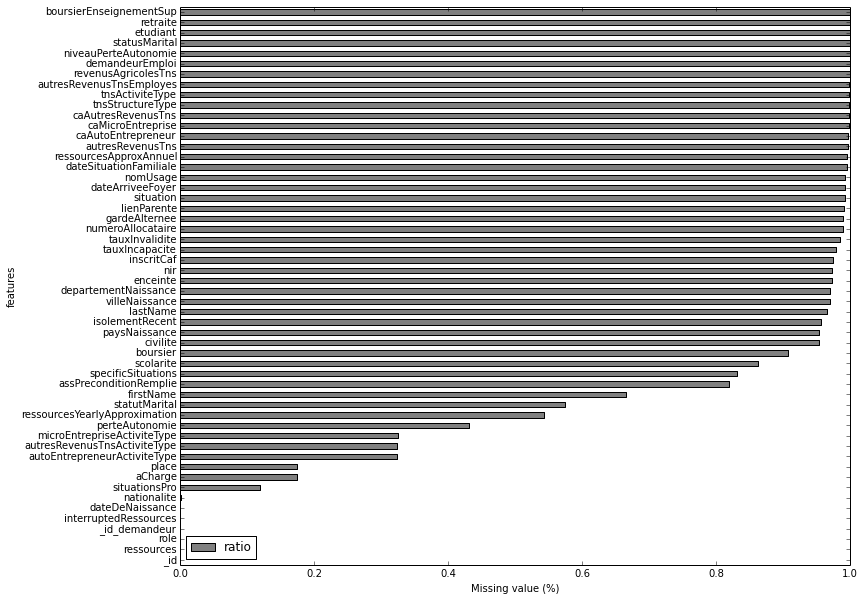

In [207]:
individus_NA.sort_values('ratio', ascending='False').plot(y= 'ratio', kind='barh', figsize=(12, 10), color='grey')
plt.xlabel('Missing value (%)')

### Enfant

In [174]:
grouped = t_individus.groupby('_id_demandeur')['role']

In [176]:
grouped.value_counts().head()

_id_demandeur             role     
53cd46e76e5e3202000f4617  demandeur    1
53cd48556e5e3202000f4625  demandeur    1
53d0c86489d7bd02003d8459  conjoint     1
                          demandeur    1
53d0d01889d7bd02003d84a4  enfant       2
dtype: int64

In [177]:
t_role = grouped.value_counts().reset_index()
t_role.columns = ['_id_demandeur', 'role', 'nb']
t_role = t_role[t_role.role != 'demandeur']
t_role.head(3)

,_id_demandeur,role,nb
2,53d0c86489d7bd02003d8459,conjoint,1
4,53d0d01889d7bd02003d84a4,enfant,2
6,53d0d35089d7bd02003d84ab,enfant,3


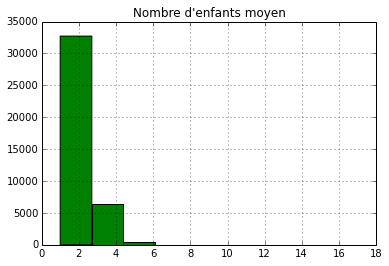

In [178]:
plt.subplot(111)
t_role[t_role.role == 'enfant']['nb'].hist(color='green')
plt.title('Nombre d\'enfants moyen')

### Situation pro

In [179]:
t_individus[['_id', '_id_demandeur', 'situationsPro']].loc[200113:200114]

,_id,_id_demandeur,situationsPro
200113,56fd555a91dac855400fd4ab,56fd555a91dac855400fd4ab,"[{'_id': ObjectId('56fd555a91dac855400fd4ac'),..."
200114,56fd555a91dac855400fd4a9,56fd555a91dac855400fd4ab,"[{'_id': ObjectId('56fd555a91dac855400fd4aa'),..."


In [22]:
situation_pro = t_individus.situationsPro.apply(lambda x: [] if (pd.isnull(x) or x == '[]') else x)

In [104]:
situation_pro = [ast.literal_eval(x.replace("ObjectId('", '\'').replace("')", '\'')) if type(x) == str else x for x in situation_pro]

In [105]:
serie = situation_pro
k = 0
for list_ind in serie:
    if len(list_ind) > 0:
        for d in list_ind:
            d['_id_demandeur'] = t_individus.iloc[k]._id
    else:
        pass
    k += 1

In [106]:
t_situations_pro = pd.DataFrame(pd.Series(situation_pro).sum())

In [108]:
t_situations_pro['_id'] = [x.replace("ObjectId('", '').replace("')", '') for x in t_situations_pro._id]

In [209]:
t_situations_pro.columns = ['_id', '_id_demandeur', 'situationsPro']
t_situations_pro.head(1)

,_id,_id_demandeur,situationsPro
0,5422b60b5be58c0200a07549,5422b60b5be58c0200a07548,demandeur_emploi


In [212]:
del t_individus['situationsPro']

In [215]:
t_individus = pd.merge(t_individus,
                       t_situations_pro[["_id_demandeur", "situationsPro"]],
                       left_on="_id_demandeur",
                       right_on="_id_demandeur")

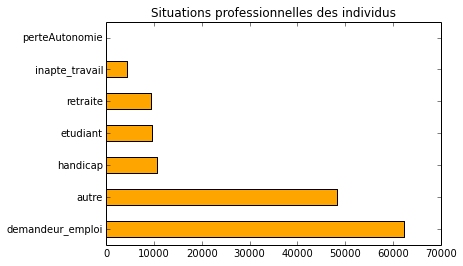

In [223]:
t_individus.situationsPro.value_counts().plot(kind='barh', color='orange')
plt.title('Situations professionnelles des individus')

### Age

In [225]:
t_individus.dateDeNaissance

0        1989-09-14
1        1989-09-14
2        1989-09-14
3        1989-09-14
4        1989-09-14
5        1989-09-14
6        1989-09-14
7        1989-09-14
8        1989-09-14
9        1987-11-29
10       1980-08-12
11       1980-08-12
12       1989-09-14
13       1989-09-14
14       1989-09-14
15       1989-09-14
16       1989-09-14
17       1989-09-14
18       1940-05-31
19       1948-10-09
20       1924-04-02
21       1973-08-05
22       2006-08-12
23       1980-08-12
24       1970-12-02
25       1991-10-22
26       1939-08-08
27       1939-08-08
28       1958-10-11
29       1982-01-01
            ...    
144361   1982-06-18
144362   1992-06-12
144363   1994-07-06
144364   1969-11-20
144365   1999-06-01
144366   1954-07-21
144367   1958-11-28
144368   1985-03-22
144369   2008-01-25
144370   2005-01-15
144371   2010-05-09
144372   1988-08-23
144373   1959-09-27
144374   1990-07-10
144375   1994-09-30
144376   1977-12-17
144377   2005-08-08
144378   2007-09-15
144379   2010-09-17


### Basic stats

In [74]:
t_individus.situationsPro.value_counts()

[]                                                                                                                                                          28251
[{'situation': 'autre', '_id': ObjectId('567ac5c13bab88c24dc09ec4')}]                                                                                           1
[{'situation': 'demandeur_emploi', '_id': ObjectId('55bd2c585382d05d729b86c2')}]                                                                                1
[{'situation': 'retraite', '_id': ObjectId('55f67466dad6d1151d57841d')}]                                                                                        1
[{'situation': 'handicap', '_id': ObjectId('56910f68b450d43f51567dd6')}]                                                                                        1
[{'situation': 'demandeur_emploi', '_id': ObjectId('5697b0d432f7d034486c035d')}]                                                                                1
[{'situation': 'retraite', '